# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
import os
!pip -q install ./python
#check and download the tennis env
if not any('Tennis' in dir for dir in os.listdir()):
    !wget "https://s3-us-west-1.amazonaws.com/udacity-drlnd/P3/Tennis/Tennis_Linux_NoVis.zip"
    !unzip "Tennis_Linux_NoVis.zip"

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import random
import torch
from collections import deque
import matplotlib.pyplot as plt
import time
#from workspace_utils import active_session 
from ddpg_agent import Agent
%matplotlib inline

env = UnityEnvironment(file_name="Tennis_Linux_NoVis/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Hyper parameters
Define Hyper parameters in the config

In [4]:
config={
    'buffer_size' : int(1e5),  # replay buffer size
    'batch_size' : 512,        # minibatch size
    'gamma' : 0.99,            # discount factor
    'tau' : 2e-1,              # for soft update of target parameters
    'lr_actor' : 1e-4,         # learning rate of the actor 
    'lr_critic' : 3e-4,        # learning rate of the critic
    'weight_decay' : 0,        # L2 weight decay
    'update_every' : 1,        # update the network after every UPDATE_EVERY timestep
    'update_times' : 1,        # update UPDATE_TIME for every update
    'epsilon' : 1,             # epsilon noise parameter
    'epsilon_decay' : 0,       # decay parameter of epsilon
    'device' : 'cpu',          #torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    'OUNoise':{'mu':0,'theta':0.15,'sigma':0.2}
}

### 4. Environment and Agent 

Reset the Environment and get the state and action info. Initilize the agent with the hyper parameters.

In [5]:
env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
action_size = brain.vector_action_space_size           # get the action size
state_size = states.shape[1]                           # get the state size
random_seed = 2
agent = Agent(state_size,action_size,num_agents,random_seed,config)      # init the agent


### 5. DDPG Trainnig and Tesing Funtion

In [7]:
def ddpg(n_episodes=2000, max_t=2000, train=True):
    start_time = time.time()
    scores_deque = deque(maxlen=100)
    all_scores = []
    scores_mean = []
    max_score = -np.Inf
    
    if not train:
        agent.load_weights('checkpoint_actor.pth','checkpoint_critic.pth')
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train)[brain_name] 
        states = env_info.vector_observations
        agent.reset()
        scores = np.zeros(num_agents)
        for t in range(max_t):
            
            actions = agent.act(states,add_noise=train)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations  # get the next state
            rewards = env_info.rewards  # get the reward
            dones = env_info.local_done # get the dones
            
            if train:
                agent.step(states, actions, rewards, next_states, dones, t)
                      
            states = next_states
            scores += rewards
            if np.any(dones):
                break       
        score = np.max(scores)
        scores_deque.append(score)
        all_scores.append(score)
        scores_mean.append(np.mean(scores_deque))
        
        if i_episode % 20 == 0 :
            duration = (int)(time.time() - start_time)  
            print('\rEpisode {}\tAverage Score: {:.2f}\tScore: P1 - {:.2f}\tP2 - {:.2f}\tepsilon {:.4f}\tTime: {:02}:{:02}:{:02}'\
                  .format(i_episode, np.mean(scores_deque),scores[0],scores[1],agent.epsilon,\
                          duration//3600, duration%3600//60, duration%60))
        else:
             print('\rEpisode {}\tAverage Score: {:.2f}\tScore: P1 - {:.2f}\tP2 - {:.2f}\tepsilon {:.2f}'\
              .format(i_episode, np.mean(scores_deque), scores[0],scores[1],agent.epsilon), end="")
                
        if np.mean(scores_deque) >= 0.5 and train :
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode , np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break  
    return all_scores,scores_mean



### 6. Train the agnet

Episode 20	Average Score: 0.01	Score: P1 - 0.00	P2 - -0.01	epsilon 1.0000	Time: 00:00:07
Episode 40	Average Score: 0.01	Score: P1 - 0.00	P2 - -0.01	epsilon 1.0000	Time: 00:00:30
Episode 60	Average Score: 0.01	Score: P1 - -0.01	P2 - 0.10	epsilon 1.0000	Time: 00:00:55
Episode 80	Average Score: 0.01	Score: P1 - -0.01	P2 - 0.00	epsilon 1.0000	Time: 00:01:29
Episode 100	Average Score: 0.01	Score: P1 - 0.09	P2 - 0.10	epsilon 1.0000	Time: 00:01:56
Episode 120	Average Score: 0.03	Score: P1 - 0.00	P2 - 0.09	epsilon 1.0000	Time: 00:02:36
Episode 140	Average Score: 0.04	Score: P1 - -0.01	P2 - 0.10	epsilon 1.0000	Time: 00:03:17
Episode 160	Average Score: 0.05	Score: P1 - 0.00	P2 - 0.09	epsilon 1.0000	Time: 00:03:58
Episode 180	Average Score: 0.06	Score: P1 - 0.00	P2 - 0.09	epsilon 1.0000	Time: 00:04:40
Episode 200	Average Score: 0.07	Score: P1 - 0.00	P2 - 0.09	epsilon 1.0000	Time: 00:05:18
Episode 220	Average Score: 0.08	Score: P1 - 0.00	P2 - 0.09	epsilon 1.0000	Time: 00:06:08
Episode 240	Average 

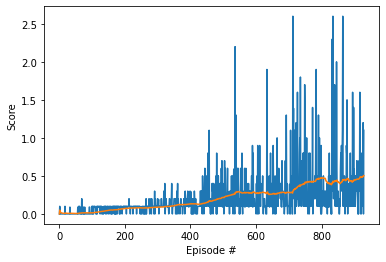

<Figure size 432x288 with 0 Axes>

In [7]:
#with active_session():
scores,scores_mean= ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores,label="score")
plt.plot(np.arange(1, len(scores_mean)+1), scores_mean,label="avg score")
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
plt.savefig('train.png')

### 7. Test the agnet

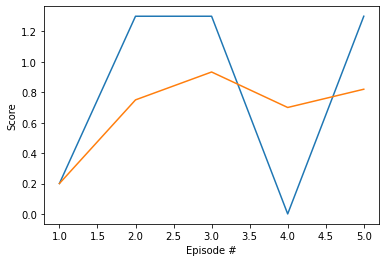

In [10]:
scores,scores_mean= ddpg(n_episodes=5, max_t=500, train=False)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores,label="score")
plt.plot(np.arange(1, len(scores_mean)+1), scores_mean,label="avg score")
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig('eval.png')